# Session 4 — Paragraph-Level Analysis
## Measure 2: Topic Drift Between Paragraphs

In this notebook, you will:
- represent each paragraph as a MiniLM embedding
- compute cosine similarity between consecutive paragraphs
- interpret low similarity as strong topic/scene shifts
- connect this to how LLM systems segment long documents
  into chunks for retrieval and long-context reasoning.


In [3]:
import re
from typing import List
import numpy as np
import matplotlib.pyplot as plt

# You may need to install this once in your environment:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

def load_book(filepath: str) -> str:
    """Load and lightly clean a book text (Project Gutenberg style)."""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    if 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]

    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]

    return text.strip()

Pet_Semetary_text = load_book('../data/PetSemetary.txt')
The_Shining_text = load_book('../data/TheShining.txt')

print(f"Pet Semetary characters: {len(Pet_Semetary_text):,}")
print(f"The Shining characters: {len(The_Shining_text):,}")


Pet Semetary characters: 812,501
The Shining characters: 906,142


In [4]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    raw_paras = re.split(r'\n\s*\n+', text)
    paras = []
    for p in raw_paras:
        cleaned = re.sub(r'\s+', ' ', p).strip()
        if not cleaned:
            continue
        if len(cleaned.split()) < min_words:
            continue
        paras.append(cleaned)
    return paras

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1:
        a = a.reshape(-1)
    if b.ndim > 1:
        b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)

def topic_drift_embeddings(paragraphs: List[str]) -> list:
    """Compute cosine similarity between consecutive paragraph embeddings.

    Low similarity = big topic shift (high drift).
    High similarity = smooth continuation.
    """
    if not paragraphs:
        return []
    para_embs = model.encode(paragraphs)
    sims = []
    for i in range(len(para_embs) - 1):
        sims.append(cosine_similarity(para_embs[i], para_embs[i+1]))
    return sims

Pet_Semetary_paras = split_into_paragraphs(Pet_Semetary_text)
The_Shining_paras = split_into_paragraphs(The_Shining_text)

w_drift = topic_drift_embeddings(Pet_Semetary_paras)
g_drift = topic_drift_embeddings(The_Shining_paras)

print(f"Pet Semetary mean similarity between consecutive paragraphs: {sum(w_drift)/len(w_drift):.3f}")
print(f"The Shining mean similarity between consecutive paragraphs: {sum(g_drift)/len(g_drift):.3f}")


Pet Semetary mean similarity between consecutive paragraphs: 0.476
The Shining mean similarity between consecutive paragraphs: 0.451


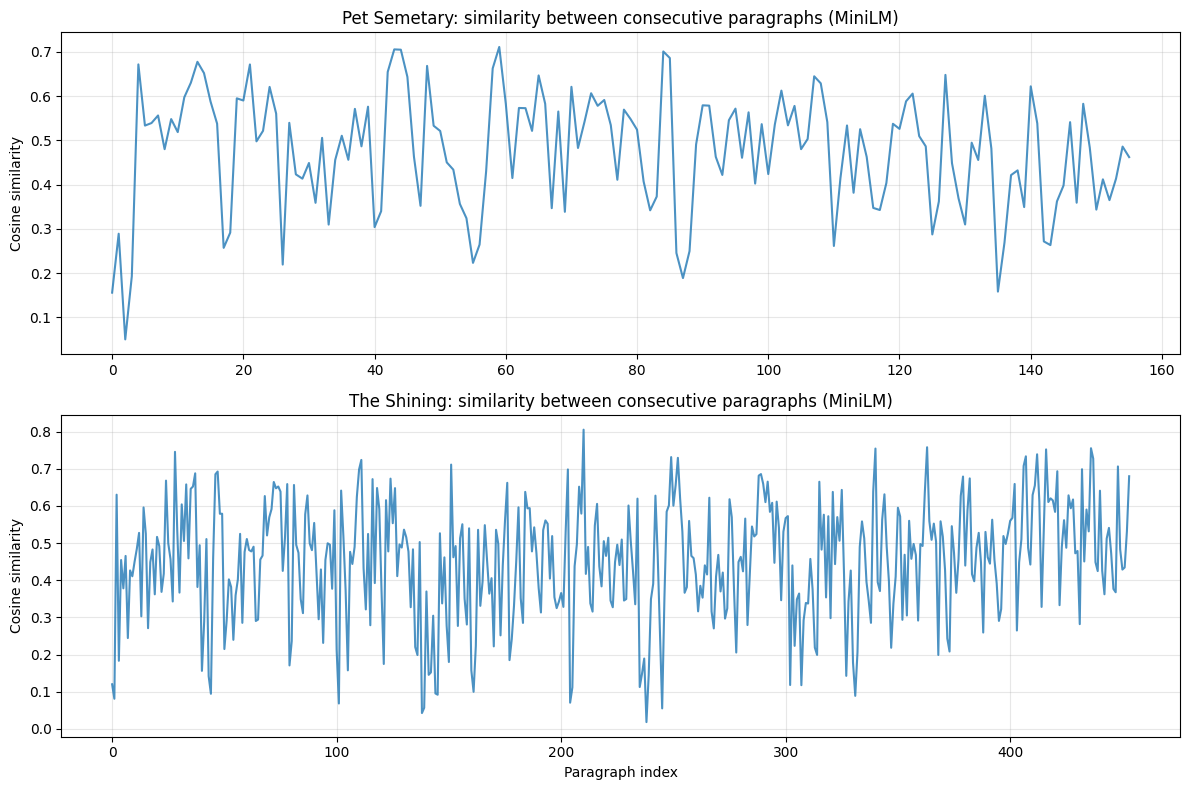

In [5]:
# Visualize topic drift as a line plot (similarity index)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

axes[0].plot(w_drift, alpha=0.8)
axes[0].set_title('Pet Semetary: similarity between consecutive paragraphs (MiniLM)')
axes[0].set_ylabel('Cosine similarity')
axes[0].grid(True, alpha=0.3)

axes[1].plot(g_drift, alpha=0.8)
axes[1].set_title('The Shining: similarity between consecutive paragraphs (MiniLM)')
axes[1].set_xlabel('Paragraph index')
axes[1].set_ylabel('Cosine similarity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


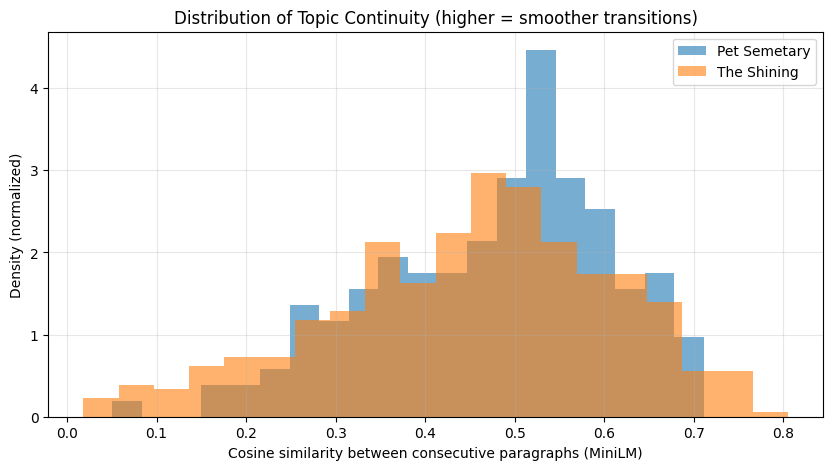

In [6]:
# Histogram comparison
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(w_drift, bins=20, alpha=0.6, label='Pet Semetary', density=True)
ax.hist(g_drift, bins=20, alpha=0.6, label='The Shining', density=True)
ax.set_xlabel('Cosine similarity between consecutive paragraphs (MiniLM)')
ax.set_ylabel('Density (normalized)')
ax.set_title('Distribution of Topic Continuity (higher = smoother transitions)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [8]:
import gc

# Delete large variables to free memory
del Pet_Semetary_text, The_Shining_text
del Pet_Semetary_paras, The_Shining_paras
del w_drift, g_drift

# Clear matplotlib figures
plt.close('all')

# Unload the model from memory
del model

# Force garbage collection
gc.collect()

print("Memory cleaned! Large variables deleted and garbage collected.")

Memory cleaned! Large variables deleted and garbage collected.
